# Algorithmic Fairness, Accountability, and Ethics, Spring 2024

## Mandatory Assignment 2

Please use the following code to prepare the dataset.
 

In [1]:
from folktables.acs import adult_filter
from folktables import ACSDataSource, BasicProblem, generate_categories
import numpy as np
from scipy.stats import pearsonr, spearmanr
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

warnings.filterwarnings("ignore")
random.seed(0)
from sklearn.utils.validation import check_random_state
check_random_state(0)

data_source = ACSDataSource(survey_year='2018', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)


def adult_filter(data):
    """Mimic the filters in place for Adult data.
    Adult documentation notes: Extraction was done by Barry Becker from
    the 1994 Census database. A set of reasonably clean records was extracted
    using the following conditions:
    ((AAGE>16) && (AGI>100) && (AFNLWGT>1)&& (HRSWK>0))
    """
    df = data
    df = df[df['AGEP'] > 16]
    df = df[df['PINCP'] > 100]
    df = df[df['WKHP'] > 0]
    df = df[df['PWGTP'] >= 1]
    df = df[df["RAC1P"] < 3] ## keep only Whites and African-Americans
    return df


ACSIncomeNew = BasicProblem(
    features=[
        'AGEP',
        'COW',
        'SCHL',
        'MAR',
        'RELP',
        'WKHP',
        'PWGTP',
        'SEX',
        'RAC1P',
    ],
    target='PINCP',
    target_transform=lambda x: x > 25000,    
    group=['SEX', 'RAC1P'],
    preprocess=adult_filter,
    postprocess=lambda x: np.nan_to_num(x, -1),
)

definition_df = data_source.get_definitions(download=True)
categories = generate_categories(features=ACSIncomeNew.features, definition_df=definition_df)
features, labels, groups = ACSIncomeNew.df_to_pandas(acs_data, categories=categories, dummies=True)

# Drop the "redundant" columns
features = features.drop(["RAC1P_White alone", 
                          "SEX_Male", 
                          "SCHL_1 or more years of college credit, no degree",  
                          "MAR_Divorced", 
                          "RELP_Adopted son or daughter",
                          'COW_Working without pay in family business or farm' ], axis = 1) 

print("Columns with the protected features:")
for i, f in enumerate(features.columns):
    if ("RAC1P" in f) or ("SEX" in f):
        print("Column ID: %s" %i, "(%s)"%f)
        
features.head()

Columns with the protected features:
Column ID: 54 (SEX_Female)
Column ID: 55 (RAC1P_Black or African American alone)


,AGEP,WKHP,PWGTP,"COW_Employee of a private for-profit company or business, or of an individual, for wages, salary, or commissions","COW_Employee of a private not-for-profit, tax-exempt, or charitable organization",COW_Federal government employee,"COW_Local government employee (city, county, etc.)","COW_Self-employed in own incorporated business, professional practice or farm","COW_Self-employed in own not incorporated business, professional practice, or farm",COW_State government employee,...,RELP_Other nonrelative,RELP_Other relative,RELP_Parent-in-law,RELP_Reference person,RELP_Roomer or boarder,RELP_Son-in-law or daughter-in-law,RELP_Stepson or stepdaughter,RELP_Unmarried partner,SEX_Female,RAC1P_Black or African American alone
0,21,20.0,52,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,65,8.0,33,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,33,40.0,53,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,18,18.0,106,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,27,50.0,23,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [2]:
### Train test split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

sample_indices = random.sample(range(len(features)), 20000)
features1, labels1 = features.iloc[sample_indices], labels.iloc[sample_indices]

X_train, X_test, y_train, y_test = train_test_split(features1, labels1, test_size=0.2, random_state=0)
# scaler = StandardScaler()
# scaler.fit(X_train)
X_train = pd.DataFrame(columns= X_train.columns, data= X_train, index = X_train.index)
X_test = pd.DataFrame(columns= X_test.columns, data = X_test, index= X_test.index)
X_train = X_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

# shuffle the index of training data
# X_train = X_train.sample(frac=1).reset_index(drop=True)


### Create one classifier to predict income on RAW DATA
lr = LogisticRegression()
lr.fit(X_train, y_train)

### Report general accuracy 
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve
from sklearn.model_selection import cross_val_score

probs = lr.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probs)
preds = accuracy_score(y_test, probs > 0.5)

print('Scores across all groups.')
print('AUC: ', auc(fpr, tpr))
print('Accuracy: ', preds)
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', lr)])
print('Overall cross val score: ', cross_val_score(pipe , X_train, y_train).mean())
print('---------------------------')

### report accuracy for gender groups and races
accuracies_female, accuracies_nonfemale = [], []
accuracies_black, accuracies_nonblack = [], []
for j in [0, 4000, 8000, 12000]:
    test = list(range(j, j+4000))
    X_test_temp = X_train.iloc[test]
    y_test_temp = y_train.iloc[test]
    X_train_temp = X_train.drop(test)
    y_train_temp = y_train.drop(test)
    pipe = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', lr)])
    pipe.fit(X_train_temp, y_train_temp)
    for i in set(X_train['RAC1P_Black or African American alone']):
        X_test_temp_group = X_test_temp[X_test_temp['RAC1P_Black or African American alone'] == i]
        y_test_temp_group = y_test_temp.loc[X_test_temp_group.index]
        temp_preds = pipe.predict(X_test_temp_group)
        accuracy = accuracy_score(y_test_temp_group, temp_preds)
        if i > 0:
            accuracies_black.append(accuracy)
        else:
            accuracies_nonblack.append(accuracy)
    for i in set(X_train['SEX_Female']):
        X_test_temp_group = X_test_temp[X_test_temp['SEX_Female'] == i]
        y_test_temp_group = y_test_temp.loc[X_test_temp_group.index]
        temp_preds = pipe.predict(X_test_temp_group)
        accuracy = accuracy_score(y_test_temp_group, temp_preds)
        if i > 0:
            accuracies_female.append(accuracy)
        else:
            accuracies_nonfemale.append(accuracy)

print(f'Accuracy for Black: {np.mean(accuracies_black)}')
print(f'Accuracy for Non-Black: {np.mean(accuracies_nonblack)}')
print(f'Accuracy for Female: {np.mean(accuracies_female)}')
print(f'Accuracy for Non-Female: {np.mean(accuracies_nonfemale)}')

Scores across all groups.
AUC:  0.8665244309282005
Accuracy:  0.8275
Overall cross val score:  0.8246875000000001
---------------------------
Accuracy for Black: 0.7939968804031764
Accuracy for Non-Black: 0.8282649754442889
Accuracy for Female: 0.8015005110695523
Accuracy for Non-Female: 0.8474603885421148


In [3]:
lambdas = np.linspace(0, 1, 101)

In [4]:
print(features['RAC1P_Black or African American alone'].value_counts()/len(features))
print(features1['RAC1P_Black or African American alone'].value_counts()/len(features1))
print(features['SEX_Female'].value_counts()/len(features))
print(features1['SEX_Female'].value_counts()/len(features1))

RAC1P_Black or African American alone
False    0.933955
True     0.066045
Name: count, dtype: float64
RAC1P_Black or African American alone
False    0.9327
True     0.0673
Name: count, dtype: float64
SEX_Female
False    0.532536
True     0.467464
Name: count, dtype: float64
SEX_Female
False    0.5329
True     0.4671
Name: count, dtype: float64


In [5]:
scaler = StandardScaler()
X_train = pd.DataFrame(data = scaler.fit_transform(X_train), columns = X_train.columns, index = X_train.index)
X_test = pd.DataFrame(data=scaler.transform(X_test), columns=X_test.columns, index=X_test.index)
Xs_train_p = X_train.values[:, 54:]
Xs_test_p = X_test.values[:, 54:]
Xs_train_np = X_train.values[:, :54]
Xs_test_np = X_test.values[:, :54]

In [6]:
# ### Create a fairer version of the dataset to protect select groups

plots = [0.96969697, 1.97979798, 3.03030303, 0.04040404]
def debias_features(Xs_np, Xs_p, lambda_param=0.7):
    import scipy
    assert Xs_np.shape[0]==Xs_p.shape[0]


    orthbasis = scipy.linalg.orth(Xs_p)

    orthbasis_projection = orthbasis @ orthbasis.T @ Xs_np
    Xs_np_debiased = Xs_np - orthbasis_projection - lambda_param * orthbasis_projection

    return Xs_np_debiased


accuracies_all = []
accuracies_sex_1 = []
accuracies_sex_2 = []
accuracies_race_1 = []
accuracies_race_2 = []
protected_cols = ['RAC1P_Black or African American alone', 'SEX_Female']

for idx, i in enumerate(lambdas):
    X_train_unprotected_debiased = debias_features(Xs_train_np, Xs_train_p, i)
    X_train_debiased = np.concatenate([X_train_unprotected_debiased, Xs_train_p], axis=1)
    # Train a classifier on the debiased data for each group
    lr.fit(X_train_debiased, y_train)
    preds = lr.predict(X_test)
    accuracy = accuracy_score(y_test, preds)
    accuracies_all.append(accuracy)
    X_test_women = X_test[X_test['SEX_Female'] > 0]
    X_test_men = X_test[X_test['SEX_Female'] < 0]
    y_test_men = y_test.loc[X_test_men.index]
    y_test_women = y_test.loc[X_test_women.index]
    X_test_black = X_test[X_test['RAC1P_Black or African American alone'] > 0]
    X_test_non_black = X_test[X_test['RAC1P_Black or African American alone'] < 0]
    y_test_black = y_test.loc[X_test_black.index]
    y_test_non_black = y_test.loc[X_test_non_black.index]
    accuracies_race_1.append(accuracy_score(y_test_black, lr.predict(X_test_black)))
    accuracies_race_2.append(accuracy_score(y_test_non_black, lr.predict(X_test_non_black)))
    accuracies_sex_1.append(accuracy_score(y_test_women, lr.predict(X_test_women)))
    accuracies_sex_2.append(accuracy_score(y_test_men, lr.predict(X_test_men)))

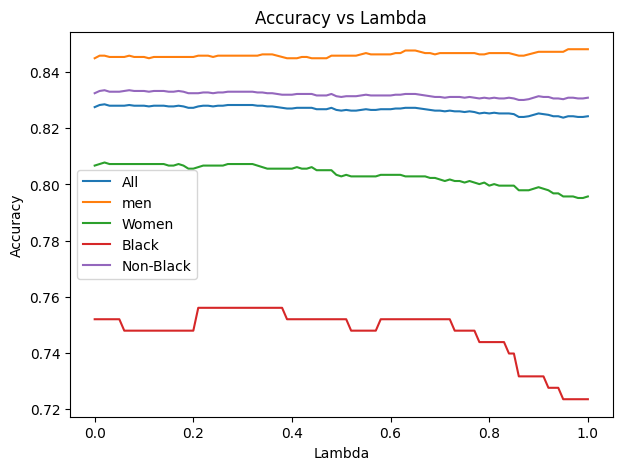

In [7]:
stats = pd.DataFrame()
stats.index = lambdas
stats['All'] = accuracies_all
stats['Women'] = accuracies_sex_1
stats['Men'] = accuracies_sex_2
stats['Black'] = accuracies_race_1
stats['Non-Black'] = accuracies_race_2

plt.figure(figsize=(7, 5))
sns.lineplot(data=stats, x = stats.index, y = stats['All'], label = 'All', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Men', label = 'men', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Women', label = 'Women', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Black', label = 'Black', markers=True)
sns.lineplot(data=stats, x = stats.index, y = 'Non-Black', label = 'Non-Black', markers=True)

plt.xlabel('Lambda')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Lambda')
plt.show()

Accuracy for Black [0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7479674796747967, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7560975609756098, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 0.7520325203252033, 

Text(0.5, 1.0, 'Difference Between groups at Lambda Values')

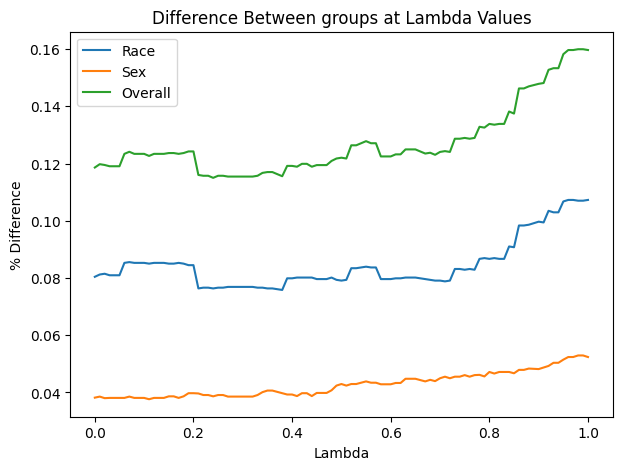

In [8]:
print('Accuracy for Black', accuracies_race_1)
print('Accuracy for Non-Black', accuracies_race_2)
print('Accuracy for Women', accuracies_sex_1)
print('Accuracy for Men', accuracies_sex_2)
print('Accuracy for all', accuracies_all)

diff_sex = []
diff_race = []
for i in zip(accuracies_race_1, accuracies_race_2, accuracies_sex_1, accuracies_sex_2):
    diff_race.append(abs( i[0] - i[1]))
    diff_sex.append(abs(i[2] - i[3]))
overall_diff = []
for i in zip(diff_race, diff_sex):
    overall_diff.append(i[0] + i[1])
plt.figure(figsize=(7, 5))
sns.lineplot(x=stats.index, y = diff_race, label = 'Race')
sns.lineplot(x = stats.index, y = diff_sex, label = 'Sex')
sns.lineplot(x = stats.index, y = overall_diff, label = 'Overall')
plt.ylabel('% Difference')
plt.xlabel('Lambda')
plt.title('Difference Between groups at Lambda Values')

In [9]:
# print accuracy at lambda = [0.0, 0.3, 0.5, 0.6, 1]
print('Accuracy at lambda = 0.0: ', stats.loc[0])
print('Accuracy at lambda = 0.3: ', stats.loc[0.3])
print('Accuracy at lambda = 0.5: ', stats.loc[0.5])
print('Accuracy at lambda = 0.6: ', stats.loc[0.6])
print('Accuracy at lambda = 1: ', stats.loc[1])

Accuracy at lambda = 0.0:  All          0.827500
Women        0.806700
Men          0.844883
Black        0.752033
Non-Black    0.832445
Name: 0.0, dtype: float64
Accuracy at lambda = 0.3:  All          0.828250
Women        0.807249
Men          0.845801
Black        0.756098
Non-Black    0.832978
Name: 0.3, dtype: float64
Accuracy at lambda = 0.5:  All          0.826250
Women        0.802856
Men          0.845801
Black        0.752033
Non-Black    0.831113
Name: 0.5, dtype: float64
Accuracy at lambda = 0.6:  All          0.826750
Women        0.803405
Men          0.846260
Black        0.752033
Non-Black    0.831646
Name: 0.6, dtype: float64
Accuracy at lambda = 1:  All          0.824250
Women        0.795717
Men          0.848095
Black        0.723577
Non-Black    0.830847
Name: 1.0, dtype: float64


## Pearson correlation plots

In [10]:
def test(lambdas_):
    X_train_unprotected_debiased = debias_features(Xs_train_np, Xs_train_p, lambdas_)
    X_train_debiased = np.concatenate([X_train_unprotected_debiased, Xs_train_p], axis=1)
    n_features = X_train.shape[1]
    corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(n_features):
            corr_[i,j], p_[i,j] = pearsonr(X_train_debiased[:,i], X_train_debiased[:,j])
            corr_ = np.nan_to_num(corr_, 0)
    return corr_
    
corr1 = test(0)
corr2 = test(0.5)
corr3 = test(1)

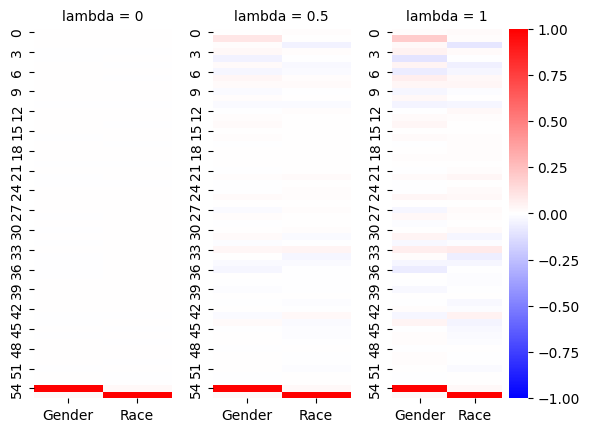

In [11]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)

y = ['Gender', 'Race']

sns.heatmap(corr1[:,54:], cmap="bwr", xticklabels=y, vmin=-1, vmax=1, ax=ax1, cbar=False)

sns.heatmap(corr2[:,54:], cmap="bwr", xticklabels=y, vmin=-1, vmax=1, ax=ax2, cbar=False)

sns.heatmap(corr3[:,54:], cmap="bwr", xticklabels=y, vmin=-1, vmax=1, ax=ax3)

fig.subplots_adjust(wspace=0.3)


# plt.suptitle('\n'.join(["Pearson's Correlation Coeff between SEX and other variables (Masked by p value)"]), y=1.02)
ax1.set_title("lambda = " + str(0), fontsize=10)
ax2.set_title("lambda = " + str(0.5), fontsize=10)
ax3.set_title("lambda = " + str(1), fontsize=10)

plt.show()

# Task 2.2 - FairPCA

## Reprojecting data using FairPCA

We use the FairPCA method from the exercise 7 solution.

In [12]:
import scipy

In [13]:
class FairPCA:
    def __init__(self, Xs, p_idxs, n_components):
        self.fit(Xs, p_idxs, n_components)

    def fit(self, Xs, p_idxs, n_components):
        # Extract protected features
        Xs_p = Xs[:, p_idxs]

        # Compute projection matrix (U)
        Z = Xs_p
        # Z = Z - Z.mean(0) # Since we alredy standardised everything, there is not much sense in removing the mean
        R = scipy.linalg.null_space(Z.T @ Xs)
        eig_vals, L = scipy.linalg.eig(R.T @ Xs.T @ Xs @ R)
        self.U = R @ L[:, :n_components]

    def project(self, Xs):
        return Xs @ self.U

### Running FairPCA + Calculating Accuracies and Absolute Differences

Below cell loops from 54 to 1 $(i)$, and for each loop:
 - Uses above FairPCA method to reproject the data down to $i$ dimensions
 - Fits a new model to the reprojected data
 - Seperates the data by the projected groups
 - Calculates accuracies for each of the groups
 - Calculates absolute difference of the accuracies between the groups
 - Stores the accuracies and absolute difference into the Pandas DataFrame "fairPCA_graph_df" for later graphing

The cell can take up to 10 minutes depending on your machine.

In [14]:
pipe = Pipeline(steps=[('scaler', StandardScaler()), ('classifier', lr)])

# Do FairPCA from 53 and all the way down to 1 dimension, plotting for each dimension
fairPCA_graph_df = pd.DataFrame()
for i in reversed(range(1, 54)):
    # do fairPCA
    fair_pca = FairPCA(X_train.to_numpy(), [54, 55], i)
    X_train_debiased = fair_pca.project(X_train)
    X_test_debiased = fair_pca.project(X_test)

    # fit model
    pipe.fit(X_train_debiased, y_train)

    # seperate by groups
    test_women_idx = X_test[X_test['SEX_Female'] > 0].index
    X_test_debiased_women = X_test_debiased.iloc[test_women_idx, :]
    y_test_women = y_test.iloc[test_women_idx, :]

    test_men_idx = X_test[X_test['SEX_Female'] < 0].index
    X_test_debiased_men = X_test_debiased.iloc[test_men_idx, :]
    y_test_men = y_test.iloc[test_men_idx, :]

    test_black_idx = X_test[X_test['RAC1P_Black or African American alone'] > 0].index
    X_test_debiased_black = X_test_debiased.iloc[test_black_idx, :]
    y_test_black = y_test.iloc[test_black_idx, :]

    test_non_black_idx = X_test[X_test['RAC1P_Black or African American alone'] < 0].index
    X_test_debiased_non_black = X_test_debiased.iloc[test_non_black_idx, :]
    y_test_non_black = y_test.iloc[test_non_black_idx, :]

    # calculate accuracies
    accuracy_all = accuracy_score(y_test, pipe.predict(X_test_debiased))
    accuracy_women = accuracy_score(y_test_women, pipe.predict(X_test_debiased_women))
    accuracy_men = accuracy_score(y_test_men, pipe.predict(X_test_debiased_men))
    accuracy_black = accuracy_score(y_test_black, pipe.predict(X_test_debiased_black))
    accuracy_non_black = accuracy_score(y_test_non_black, pipe.predict(X_test_debiased_non_black))

    # storing stats
    fairPCA_graph_df.loc[i, 'Accuracy All'] = accuracy_all
    fairPCA_graph_df.loc[i, 'Accuracy Women'] = accuracy_women
    fairPCA_graph_df.loc[i, 'Accuracy Men'] = accuracy_men
    fairPCA_graph_df.loc[i, 'Accuracy Black'] = accuracy_black
    fairPCA_graph_df.loc[i, 'Accuracy Non-Black'] = accuracy_non_black

    # calcing and storing absolute differences
    abs_diff = 0
    groups = [accuracy_all, accuracy_women, accuracy_men, accuracy_black, accuracy_non_black]
    for group_a in groups:
        for group_b in groups:
            abs_diff += abs(group_a - group_b)
    fairPCA_graph_df.loc[i, 'Difference'] = abs_diff

    # optional prints
    # print(f'========== Dimension {i} ==========')
    # print(f'Accuracy All:        {round(accuracy_all*100, 2)}')
    # print(f'Accuracy Women:      {round(accuracy_women*100, 2)}')
    # print(f'Accuracy Men:        {round(accuracy_men*100, 2)}')
    # print(f'Accuracy Black:      {round(accuracy_black*100, 2)}')
    # print(f'Accuracy Non-Black:  {round(accuracy_non_black*100, 2)}')
    # print(f'Absolute difference: {abs_diff}\n')

fairPCA_graph_df.head()

,Accuracy All,Accuracy Women,Accuracy Men,Accuracy Black,Accuracy Non-Black,Difference
53,0.81850,0.801757,0.832492,0.756098,0.822589,0.694483
52,0.81850,0.801757,0.832492,0.756098,0.822589,0.694483
51,0.81850,0.801757,0.832492,0.756098,0.822589,0.694483
50,0.81700,0.799561,0.831574,0.747967,0.821524,0.756705
49,0.81875,0.800659,0.833869,0.752033,0.823122,0.744542


### Plotting Accuracies

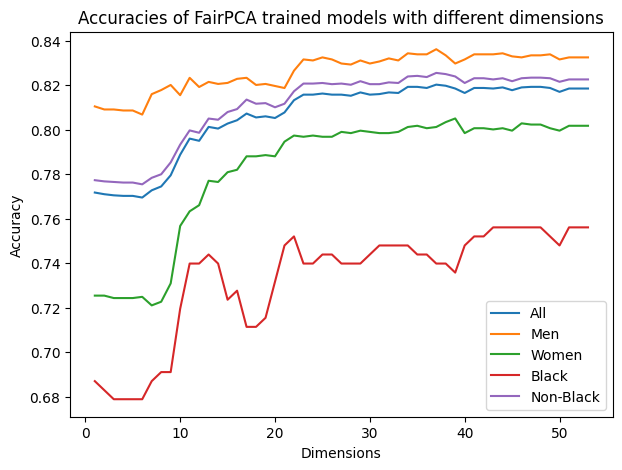

In [15]:
plt.figure(figsize=(7, 5))
sns.lineplot(data=fairPCA_graph_df, x=fairPCA_graph_df.index, y='Accuracy All', label='All', markers=True)
sns.lineplot(data=fairPCA_graph_df, x=fairPCA_graph_df.index, y='Accuracy Men', label='Men', markers=True)
sns.lineplot(data=fairPCA_graph_df, x=fairPCA_graph_df.index, y='Accuracy Women', label='Women', markers=True)
sns.lineplot(data=fairPCA_graph_df, x=fairPCA_graph_df.index, y='Accuracy Black', label='Black', markers=True)
sns.lineplot(data=fairPCA_graph_df, x=fairPCA_graph_df.index, y='Accuracy Non-Black', label='Non-Black', markers=True)
plt.title('Accuracies of FairPCA trained models with different dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Accuracy')
# move legend to bottom right
plt.legend(loc='lower right')
plt.show()

### Plotting Absolute Differences

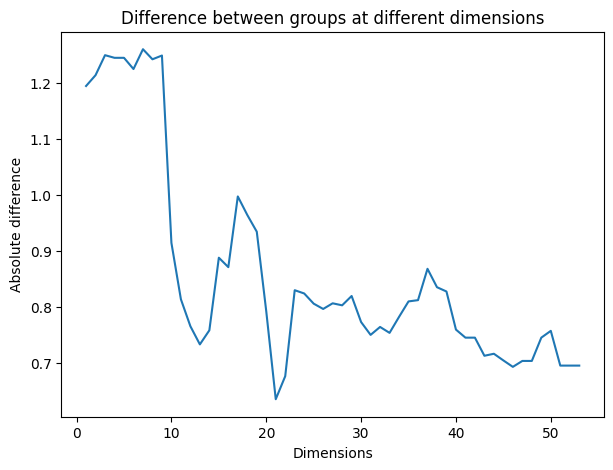

In [16]:
# plot the absolute differences
plt.figure(figsize=(7, 5))
sns.lineplot(data=fairPCA_graph_df, x=fairPCA_graph_df.index, y='Difference', markers=True)
plt.title('Difference between groups at different dimensions')
plt.xlabel('Dimensions')
plt.ylabel('Absolute difference')
plt.show()

### Correlation Coeff Visualizations on FairPCA down to 21 and 30 dimensions

This ended up not making the cut for the paper due to max page limit.

It is however interesting to see that pearsons correlation shows no correlations (even if the data is reprojected to the same dimensions as original), but the spearmans correlation shows there are still some correlations in the data.

In [17]:
def corr_vis(dim, return_=False):
    fair_pca = FairPCA(X_train.to_numpy(), [54, 55], dim)
    Xs_train_debiased = fair_pca.project(X_train)

    # Compute correlation matrix
    Xs_train_debiased_p = np.concatenate([Xs_train_debiased, Xs_train_p], axis=1)
    n_features = Xs_train_debiased_p.shape[1]
    pear_corr_ = np.zeros((n_features, n_features))
    p_ = np.zeros((n_features, n_features))
    spear_corr_ = np.zeros((n_features, n_features))
    s_ = np.zeros((n_features, n_features))
    for i in range(n_features):
        for j in range(n_features):
            pear_corr_[i,j], p_[i,j] = pearsonr(Xs_train_debiased_p[:,i], Xs_train_debiased_p[:,j])
            pear_corr_ = np.nan_to_num(pear_corr_, 0)
            spear_corr_[i,j], s_[i,j] = spearmanr(Xs_train_debiased_p[:,i], Xs_train_debiased_p[:,j])
            spear_corr_ = np.nan_to_num(spear_corr_, 0)
    
    # return the spearman values for making later combined figure
    if return_:
        return spear_corr_[:,-2:], features.columns[-2:]

    # Plot pearson correlations with protected features
    plt.figure(figsize=(4,15))
    sns.heatmap(pear_corr_[:,-2:], cmap="bwr", xticklabels=features.columns[-2:], vmin=-1, vmax=1)
    plt.title("Pearson's Correlation Coeff between protected variables and components (Masked by p value)")
    plt.show()

    # Plot spearman correlations with protected features
    plt.figure(figsize=(4,15))
    sns.heatmap(spear_corr_[:,-2:], cmap="bwr", xticklabels=features.columns[-2:], vmin=-1, vmax=1)
    plt.title("Spearman's Correlation Coeff between protected variables and components (Masked by p value)")
    plt.show()

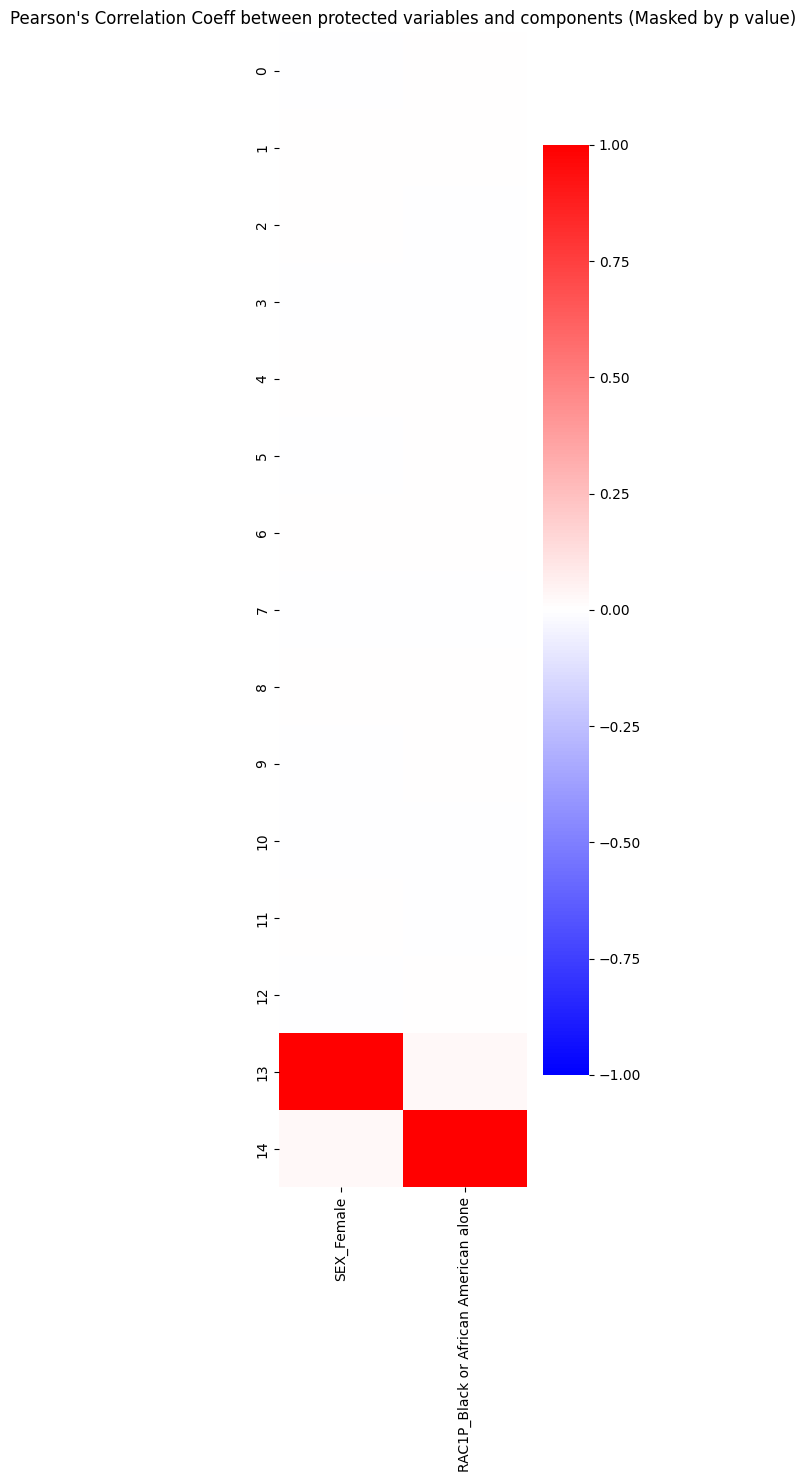

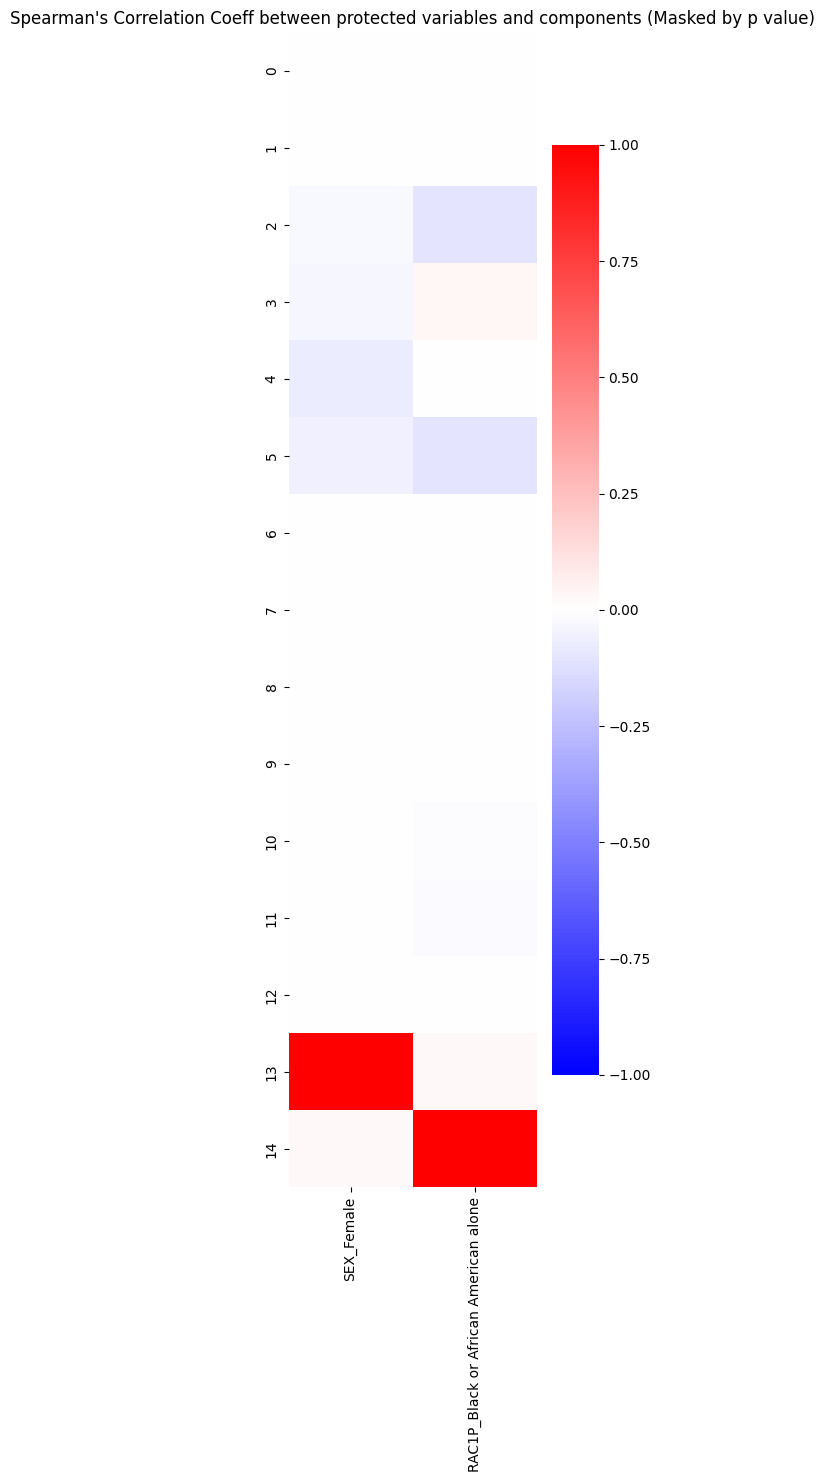

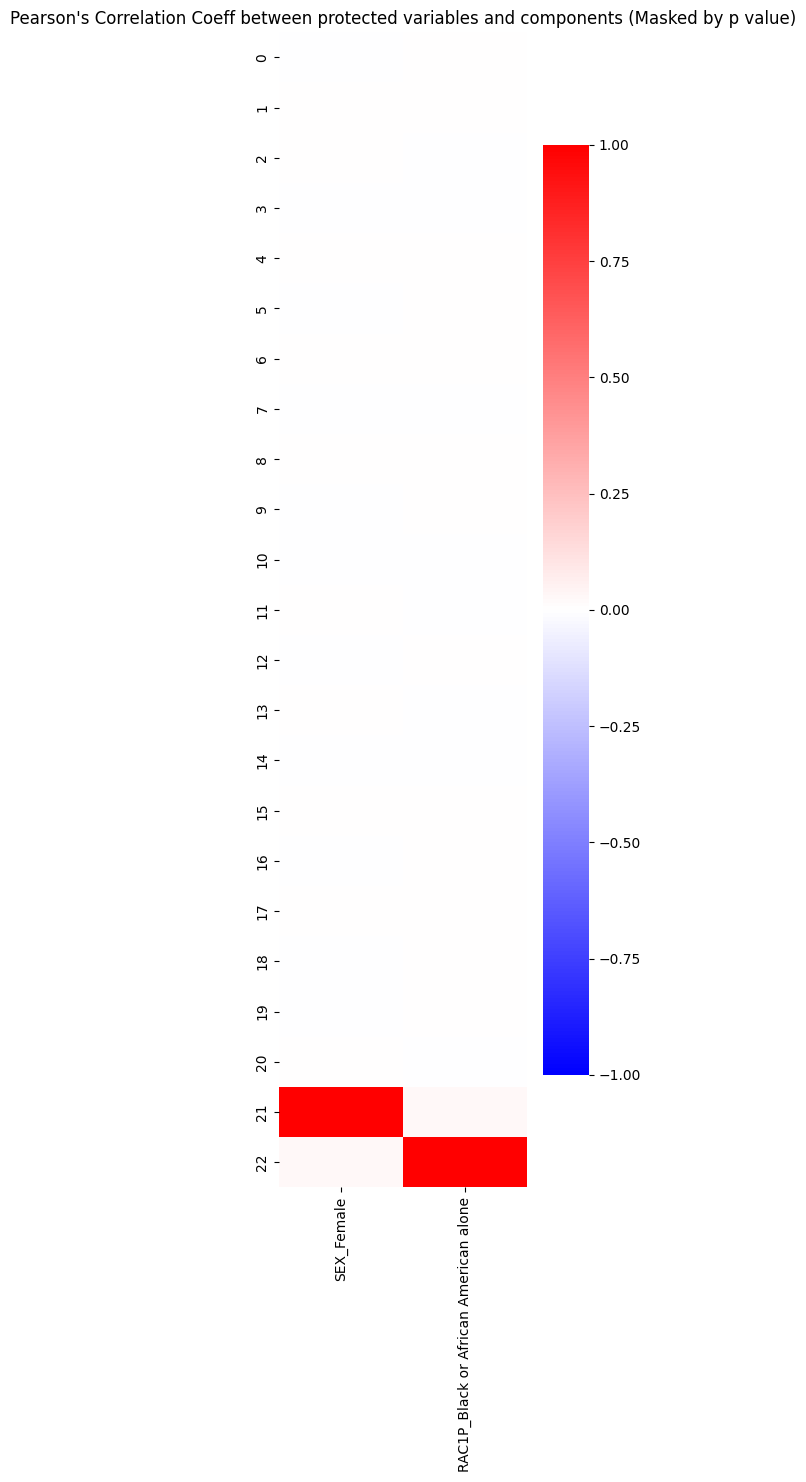

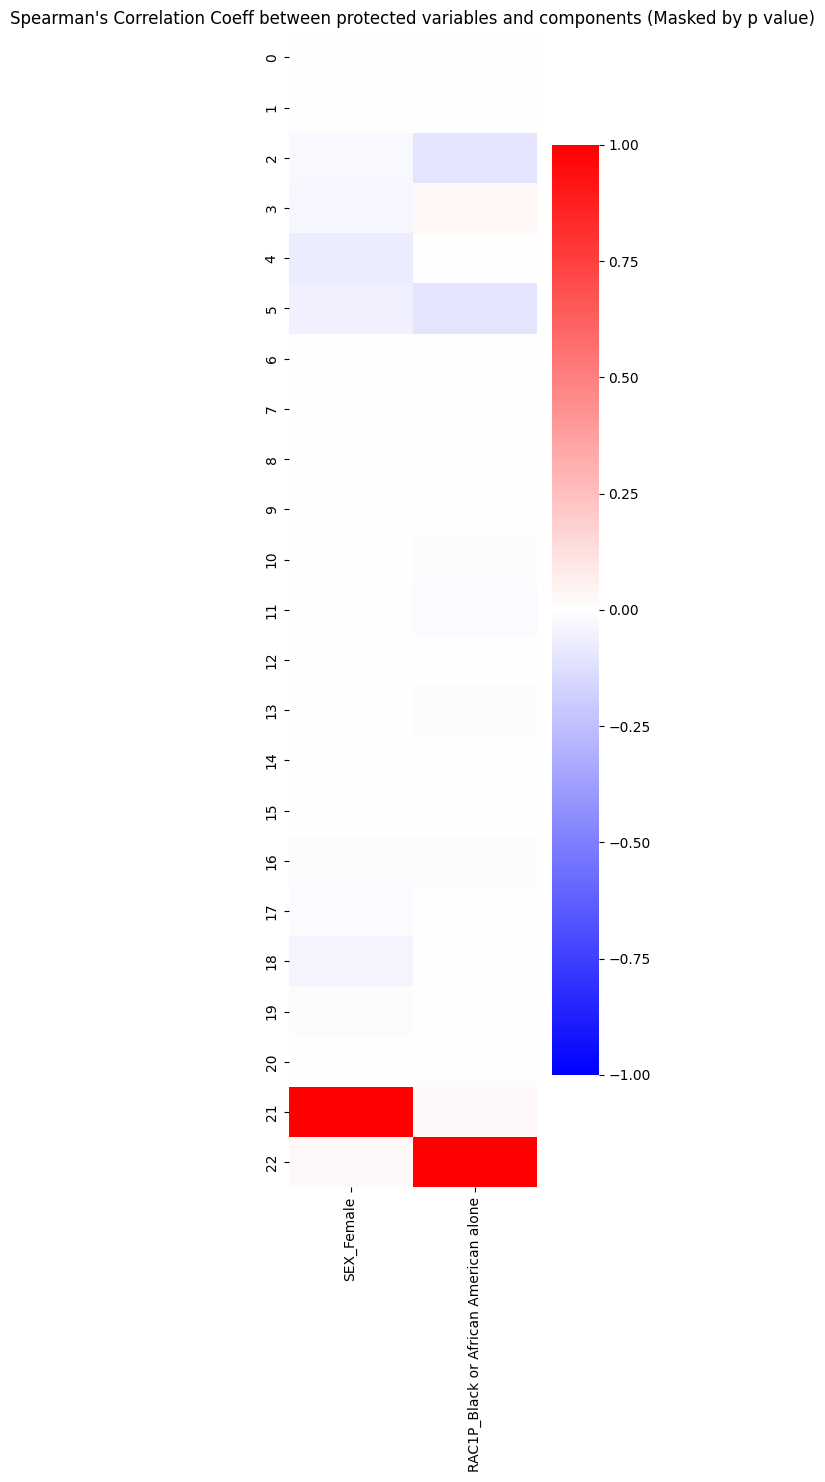

In [20]:
corr_vis(13)
corr_vis(21)

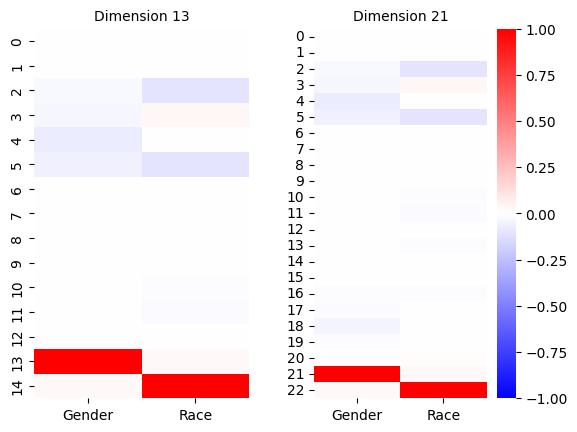

In [22]:
fig, (ax1, ax2) = plt.subplots(ncols=2)

x = ['Gender', 'Race']

# y, _ = corr_vis(30, return_=True)
# sns.heatmap(y, cmap="bwr", xticklabels=x, vmin=-1, vmax=1, ax=ax1, cbar=False)

y, _ = corr_vis(13, return_=True)
sns.heatmap(y, cmap="bwr", xticklabels=x, vmin=-1, vmax=1, ax=ax1, cbar=False)

y, _ = corr_vis(21, return_=True)
sns.heatmap(y, cmap="bwr", xticklabels=x, vmin=-1, vmax=1, ax=ax2)

fig.subplots_adjust(wspace=0.3)

# plt.suptitle('\n'.join(['Spearman Correlation between protected variables and', 'components for different FairPCA dimensions']), y=1.02)
ax1.set_title('Dimension 13', fontsize=10)
ax2.set_title('Dimension 21', fontsize=10)
plt.show()